In [1]:
import numpy as np
import pandas as pd
import sklearn
import random
import itertools
from random import sample
from statistics import mean
from scipy.stats import skew
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels

In [2]:
df = pd.read_csv('HAM10000_metadata.csv')
df.head()
# df = df[df['dx']!='nv']
df['sex'] = df['sex'].astype('category')
df['dx'] = df['dx'].astype('category')

local_dmy = pd.get_dummies(df["localization"])
df_new = pd.concat([df, local_dmy], axis=1)
df_new.drop(columns = ["localization", "lesion_id", "image_id", "dx_type"], inplace=True)

df_new["sex"] = df['sex'].cat.codes
df_new["dx"] = df['dx'].cat.codes

In [3]:
df_new.fillna(round(mean(df_new['age']), -1), inplace=True)

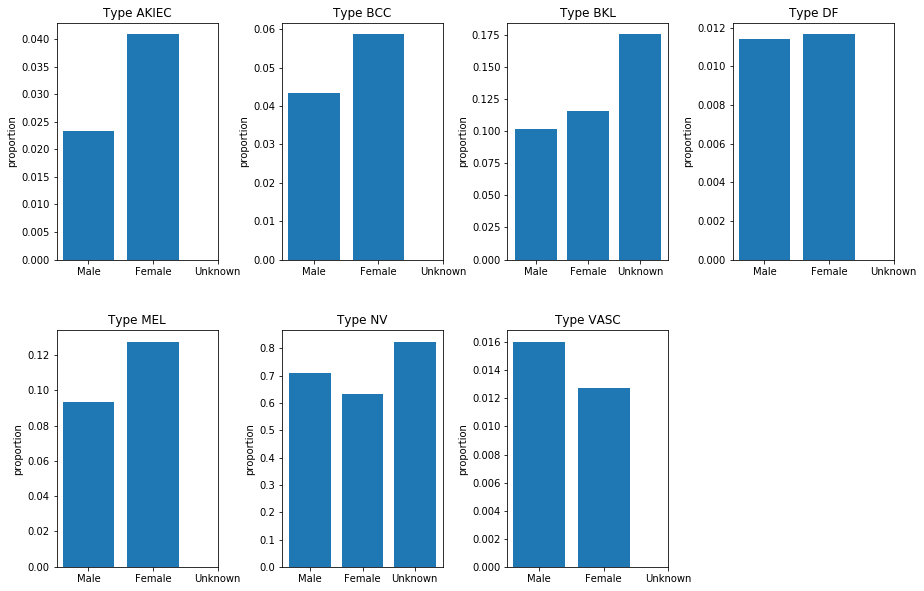

In [4]:
cancer_types = sorted(df['dx'].unique())
agex = sorted(df['sex'].unique())
total_age = df_new.groupby('sex').count()['dx']
plt.figure(figsize=(15, 10))
for i in range(7):
    plt.subplot(2, 4, 1+i)
    plt.subplots_adjust(wspace = 0.4, hspace = .3)
    age = df_new[df_new['dx']==i].groupby('sex').count()['dx']
    age_prop = [age[age.index[j]]/total_age[age.index[j]] for j, _ in enumerate(age)]
    plt.bar(age.index, age_prop)
    plt.title("Type " + cancer_types[i].upper())
#     plt.xlabel("Gender")
    plt.ylabel("proportion")
    plt.xticks(np.arange(3), ('Male', 'Female', 'Unknown'))
plt.savefig('gender_cancer.png')
plt.show()
    

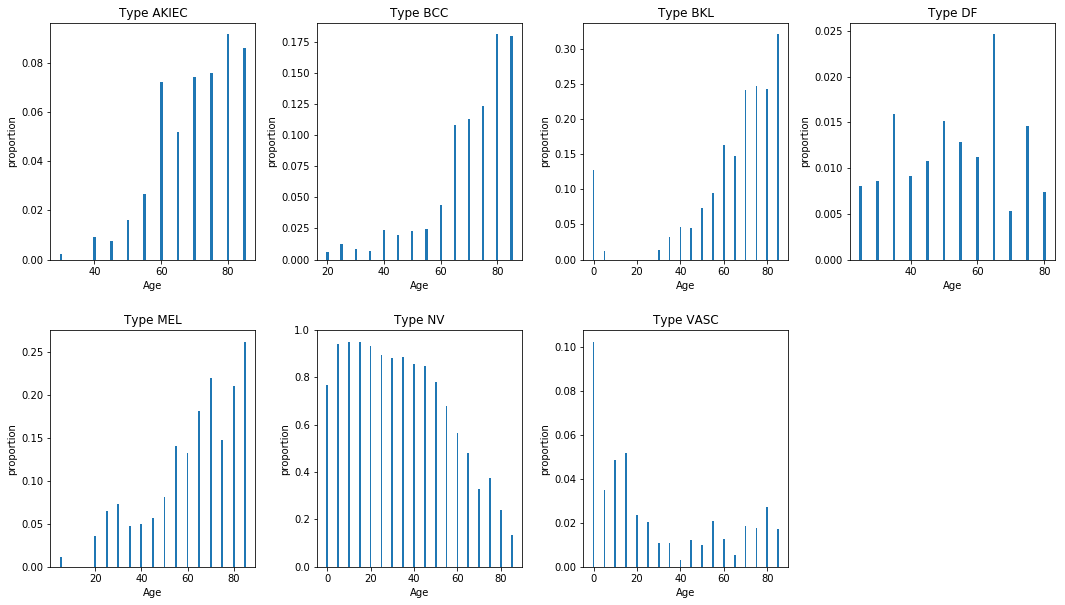

In [5]:
cancer_types = sorted(df['dx'].unique())
agex = sorted(df['age'].unique())
total_age = df_new.groupby('age').count()['dx']
plt.figure(figsize=(18, 10))
for i in range(7):
    plt.subplot(2, 4, 1+i)
    plt.subplots_adjust(wspace = 0.3, hspace=.3)
    age = df_new[df_new['dx']==i].groupby('age').count()['dx']
    age_prop = [age[age.index[j]]/total_age[age.index[j]] for j, _ in enumerate(age)]
    plt.bar(age.index, age_prop)
    plt.title("Type " + cancer_types[i].upper())
    plt.xlabel("Age")
    plt.ylabel("proportion")
plt.savefig('age_cancer.png')
plt.show()


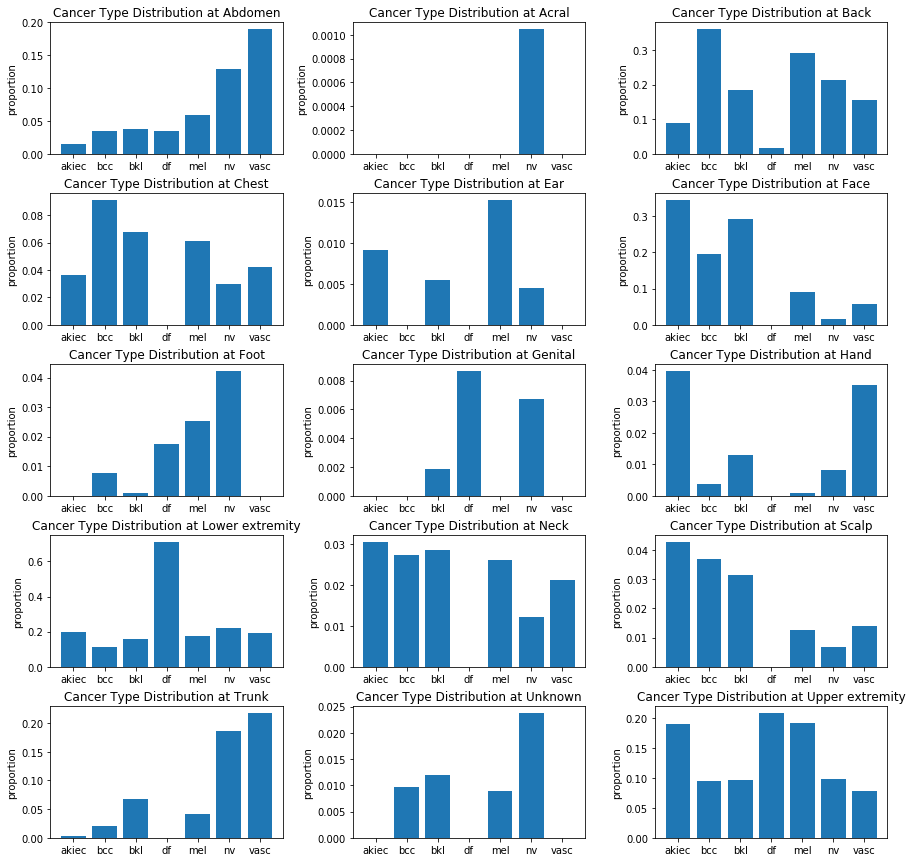

In [6]:
total_dx = df_new.groupby("dx").count()['age']
local_types = sorted(df['localization'].unique())
plt.figure(figsize=(15, 15))
for j, part in enumerate(local_types):
    dx = df_new[df_new[part]==True].groupby("dx").count()['age']
    proportion = []
    for i in range(7):
        if i in dx.index:
            proportion.append(dx[i]/total_dx[i])
        else: 
            proportion.append(0) 
    plt.subplot(5, 3, 1+j)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
    plt.bar(cancer_types, proportion)
    plt.title("Cancer Type Distribution at "+  part.capitalize())
#     plt.xlabel("type")
    plt.ylabel("proportion")
plt.savefig('local_cancer.png')
plt.show()


In [7]:
random.seed(12345)
df_new.dropna(inplace=True)
train_index = sample(list(range(len(df_new))), int(9*len(df_new)/10))
test_index = [i for i in list(range(len(df_new))) if i not in train_index]
df_np = np.array(df_new)
y_train_nv = []
y_train_non = []
y_train = []
x_train_nv = []
x_train = []
for i in train_index:
    if df_np[i][0] == 5:
        y_train_nv.append('nv')
        x_train_nv.append(df_np[i][1:])
    else:
        y_train_non.append('non-nv')
        y_train.append(df_np[i][0])
        x_train.append(df_np[i][1:])

In [8]:
y_test_nv = []
y_test_non = []
y_test = []
x_test_nv = []
x_test = []
for i in test_index:
    if df_np[i][0] == 5:
        y_test_nv.append('nv')
        x_test_nv.append(df_np[i][1:])
    else:
        y_test_non.append('non-nv')
        y_test.append(df_np[i][0])
        x_test.append(df_np[i][1:])
        
clf = RFC(n_estimators=100, max_depth=7, max_features="sqrt", class_weight="balanced")
clf.fit(x_train + x_train_nv, y_train_non + y_train_nv)

err = 0
y_test_total = y_test_non + y_test_nv
pred_test = clf.predict(x_test + x_test_nv)
pred_train = clf.predict(x_train + x_train_nv)
cm_test = confusion_matrix(pred_test, y_test_total)
cm_train = confusion_matrix(pred_train, y_train_non + y_train_nv)
test_err_rfc = zero_one_loss(pred_test, y_test_non + y_test_nv)
train_err_rfc = zero_one_loss(pred_train, y_train_non + y_train_nv)
print("Test Error: ", test_err_rfc, "Training Error: ", train_err_rfc)
for i, val in enumerate(pred_test):
    if y_test_total[i] != val:
        err += 1

Test Error:  0.22489959839357432 Training Error:  0.21546529792457036


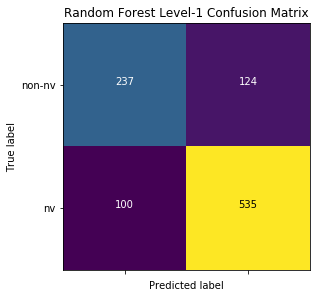

In [9]:
plt.imshow(cm_test)
plt.title("Random Forest Level-1 Confusion Matrix")
tick_marks = np.arange(2)
plt.xticks(tick_marks, [], rotation=45)
plt.yticks(tick_marks, ['non-nv', 'nv'])
thresh = cm_test.max() / 2.
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, cm_test[i, j],
             horizontalalignment="center",
             color="black" if cm_test[i, j] > thresh else "white")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('rf_cm_lvl1.png')
plt.show()

In [10]:
random.seed(12345)
clf2 = RFC(n_estimators=100, max_depth=7, max_features="sqrt", class_weight="balanced")
clf2.fit(x_train, y_train)

pred_test = clf2.predict(x_test)
pred_train = clf2.predict(x_train)
cm_test = confusion_matrix(pred_test, y_test)
cm_train = confusion_matrix(pred_train, y_train)
test_err_rfc = zero_one_loss(pred_test, y_test)
train_err_rfc = zero_one_loss(pred_train, y_train)
print("Test Error: ", test_err_rfc, "Training Error: ", train_err_rfc)

Test Error:  0.6884272997032641 Training Error:  0.6717325227963526


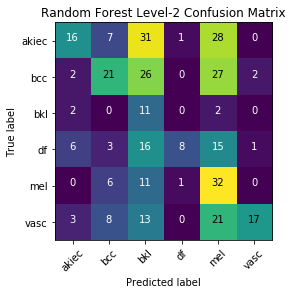

In [11]:
plt.imshow(cm_test)
plt.title("Random Forest Level-2 Confusion Matrix")
tick_marks = np.arange(6)
plt.xticks(tick_marks, ['akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc'], rotation=45)
plt.yticks(tick_marks, ['akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc'])
thresh = cm_test.max() / 2.
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, cm_test[i, j],
             horizontalalignment="center",
             color="black" if cm_test[i, j] > thresh else "white")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('rf_cm_lvl2.png')
plt.show()

In [12]:
further_test = clf.predict(x_test)
further_index = []
for i, val in enumerate(further_test):
    if val == 'non-nv':
        further_index.append(i)
y_test2 = [y_test[i] for i in further_index]
x_test2 = [x_test[i] for i in further_index]
pred_test2 = clf2.predict(x_test2)
for i, val in enumerate(pred_test2):
    if val != y_test2[i]:
        err +=1
print("Test Error: ", err/len(y_test_total))

Test Error:  0.3965863453815261


In [13]:
non_index = []
for i, val in enumerate(pred_test):
    non_index.append(i)

In [14]:
random.seed(12345)
df_new.dropna(inplace=True)
train_index = sample(range(len(df_new)), int(9*len(df_new)/10))
test_index = [i for i in range(len(df_new)) if i not in train_index]

df_np = np.array(df_new)
y_train = [df_np[i][0] for i in train_index]
x_train = [df_np[i][1:] for i in train_index]
y_test = [df_np[i][0] for i in test_index]
x_test = [df_np[i][1:] for i in test_index]

clf_ = RFC(max_features="sqrt", class_weight="balanced")
depths = [1, 2, 4, 8, 12]
estimators = [50, 100, 250, 500]
clf = GridSearchCV(clf_,
            dict(max_depth=depths,
                 n_estimators=estimators),
                 cv=5,
                 n_jobs=8)
clf.fit(x_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'max_depth': [1, 2, 4, 8, 12], 'n_estimators': [50, 100, 250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
clf.best_params_

{'max_depth': 8, 'n_estimators': 100}

In [16]:
1 - clf.best_score_

0.558134345012274

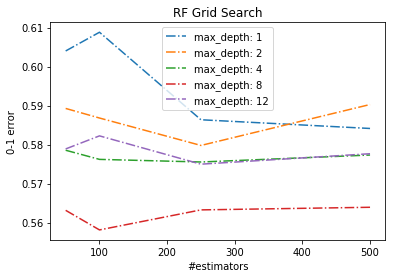

In [17]:
scores = [1-i for i in clf.cv_results_['mean_test_score']]
scores = np.array(scores).reshape(len(depths), len(estimators))

for ind, i in enumerate(depths):
    plt.plot(estimators, scores[ind], label='max_depth: ' + str(i), linestyle='-.')
plt.legend()
plt.title('RF Grid Search')
plt.xlabel('#estimators')
plt.ylabel('0-1 error')
plt.savefig('rf_gridsearch.png')
plt.show()

In [18]:
clf = RFC(n_estimators=clf.best_params_['n_estimators'], max_depth=clf.best_params_['max_depth'], max_features="sqrt", class_weight="balanced")
clf.fit(x_train, y_train)

pred_test = clf.predict(x_test)
pred_train = clf.predict(x_train)
cm_test = confusion_matrix(pred_test, y_test)
cm_train = confusion_matrix(pred_train, y_train)
test_err_rfc = zero_one_loss(pred_test, y_test)
train_err_rfc = zero_one_loss(pred_train, y_train)
print("Test Error: ", test_err_rfc, "Training Error: ", train_err_rfc)

Test Error:  0.5542168674698795 Training Error:  0.5419549207766123


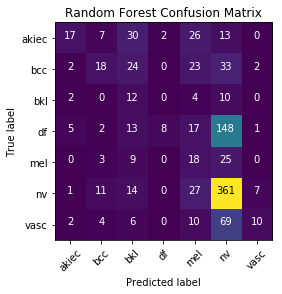

In [19]:
plt.imshow(cm_test)
plt.title("Random Forest Confusion Matrix")
tick_marks = np.arange(len(cancer_types))
plt.xticks(tick_marks, cancer_types, rotation=45)
plt.yticks(tick_marks, cancer_types)
thresh = cm_test.max() / 2.
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, cm_test[i, j],
             horizontalalignment="center",
             color="black" if cm_test[i, j] > thresh else "white")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('rf_cm.png')
plt.show()

In [20]:
clf_ = SVC(kernel='rbf', cache_size=200, class_weight="balanced")
Cs = [1, 10, 100]
Gammas = [1e-1,1e-2,1e-3, 1e-4]
clf = GridSearchCV(clf_,
            dict(C=Cs,
                 gamma=Gammas),
                 cv=5,
                 n_jobs=8)
clf.fit(x_train,y_train)

/Users/yinghanchen/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
clf.cv_results_

/Users/yinghanchen/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/yinghanchen/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/yinghanchen/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/yingha

{'mean_fit_time': array([ 9.43567042, 15.41452141, 17.46715569, 19.21556673,  9.88139372,
        12.68632436, 14.79302731, 15.38571448,  8.82208195, 15.21424809,
        18.03292527, 12.03498974]),
 'std_fit_time': array([0.73766986, 0.9877596 , 0.43428946, 0.56300984, 1.20282189,
        0.13356374, 0.1923289 , 0.1278443 , 0.55721516, 0.5548579 ,
        1.255577  , 1.43273871]),
 'mean_score_time': array([0.94679775, 1.20085106, 1.17461357, 1.24311929, 0.92994304,
        1.00374351, 0.99363165, 1.00811996, 1.01322346, 1.08283372,
        0.77788949, 0.68834367]),
 'std_score_time': array([0.05944701, 0.12730453, 0.09926599, 0.13760681, 0.15200205,
        0.05284529, 0.02590725, 0.04221726, 0.15268067, 0.05414401,
        0.1562442 , 0.2373928 ]),
 'param_C': masked_array(data=[1, 1, 1, 1, 10, 10, 10, 10, 100, 100, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
         

In [22]:
clf.best_params_

{'C': 1, 'gamma': 0.001}

In [23]:
1 - clf.best_score_

0.5524436509707655

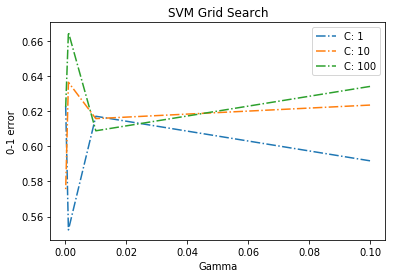

In [24]:
scores = [1-i for i in clf.cv_results_['mean_test_score']]
scores = np.array(scores).reshape(len(Cs), len(Gammas))

for ind, i in enumerate(Cs):
    plt.plot(Gammas, scores[ind], label='C: ' + str(i), linestyle='-.')
plt.legend()
plt.title('SVM Grid Search')
plt.xlabel('Gamma')
plt.ylabel('0-1 error')
plt.savefig('svm_params.png')
plt.show()

In [25]:
svm_clf = SVC(C=clf.best_params_['C'], gamma=clf.best_params_['gamma'], cache_size=200, class_weight="balanced")
svm_clf.fit(x_train, y_train)
pred_test = svm_clf.predict(x_test)
pred_train = svm_clf.predict(x_train)
cm_test = confusion_matrix(pred_test, y_test)
cm_train = confusion_matrix(pred_train, y_train)
test_err_svm = zero_one_loss(pred_test, y_test)
train_err_svm = zero_one_loss(pred_train, y_train)
print("Test Error: ", test_err_svm, "Training Error: ", train_err_svm)

Test Error:  0.5943775100401607 Training Error:  0.5756527560812319


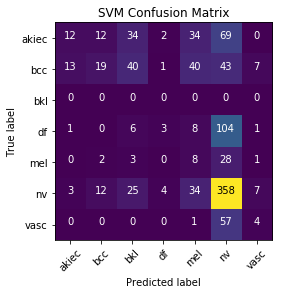

In [26]:
plt.imshow(cm_test)
plt.title("SVM Confusion Matrix")
tick_marks = np.arange(len(cancer_types))
plt.xticks(tick_marks, cancer_types, rotation=45)
plt.yticks(tick_marks, cancer_types)
thresh = cm_test.max() / 2.
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, cm_test[i, j],
             horizontalalignment="center",
             color="black" if cm_test[i, j] > thresh else "white")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('svm_cm.png')
plt.show()

In [27]:
confusion_matrix(pred_test, y_test)

array([[ 12,  12,  34,   2,  34,  69,   0],
       [ 13,  19,  40,   1,  40,  43,   7],
       [  0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   6,   3,   8, 104,   1],
       [  0,   2,   3,   0,   8,  28,   1],
       [  3,  12,  25,   4,  34, 358,   7],
       [  0,   0,   0,   0,   1,  57,   4]])

In [28]:
cm_train

array([[ 126,  139,  299,   23,  257,  694,   23],
       [ 103,  220,  375,   11,  268,  430,   26],
       [   0,    0,    0,    0,    0,    0,    0],
       [  20,   15,   72,   45,  130,  887,    7],
       [  13,   26,   42,    0,   88,  262,    7],
       [  36,   68,  185,   26,  237, 3307,   42],
       [   0,    1,    8,    0,    6,  421,   17]])